# Domain Generalization for Pathology

This notebook initiates an exploratory data analysis (EDA) of the CAMELYON17 dataset, which is a critical first step in a domain generalization study.

In the context of this project, each of the five contributing medical centers is treated as a separate 'domain'. The core challenge of domain generalization is to train a robust model on data from these source domains so that it can accurately make predictions on data from a completely new, unseen hospital.

This initial analysis is designed to characterize and quantify the "domain shift" across the different centers by investigating:
*   The distribution of Whole Slide Images (WSIs) and patients across each domain (hospital).
*   The prevalence and distribution of metastasis labels within the training set.
*   Potential imbalances or biases in how data and labels are distributed among the domains, which is a key challenge for generalization.

The script executed below will generate and save visualizations of these distributions and produce a master CSV file. This file consolidates all the necessary information and explicitly annotates the source hospital as the 'domain' for each slide, setting the stage for training and evaluating domain generalization models.


In [ ]:
from source.analysis import summarize_dataset

summarize_dataset.generate_dataset_statistics()

# Download Data Files

 In this section we download the raw TIF files (Whole Slide Images) from the CAMELYON17 dataset. These images are high-resolution scans of lymph node tissue biopsies obtained from different medical centers. Each TIF file contains a complete microscopic scan of a lymph node section that will be used to detect metastatic tissue.

 **Note**: The full dataset is very large (hundreds of gigabytes). The script below is configured to download a small subset (data for the first 2 patients) for demonstration purposes. To download the entire dataset, you can remove the `max_patients` argument from the function call.

 These images form the core data that we'll analyze to study domain generalization across different hospitals' imaging systems and protocols.


In [1]:
from source.dataset import download_dataset

download_dataset.download_tif_files(max_patients=1)

Dataset directory: /home/dagopa/data/CAMELYON17/WSI
S3 Source: s3://camelyon-dataset/CAMELYON17/images/
Listing all available files from S3...
Limiting download to the first 1 patients.
Identified 5 slides for 1 patients.
Found 5 TIFF files to process.

Processing s3://camelyon-dataset/CAMELYON17/images/patient_000_node_0.tif...
File 'patient_000_node_0.tif' already exists and size matches. Skipping download.

Processing s3://camelyon-dataset/CAMELYON17/images/patient_000_node_1.tif...
File 'patient_000_node_1.tif' already exists and size matches. Skipping download.

Processing s3://camelyon-dataset/CAMELYON17/images/patient_000_node_2.tif...
File 'patient_000_node_2.tif' already exists and size matches. Skipping download.

Processing s3://camelyon-dataset/CAMELYON17/images/patient_000_node_3.tif...
File 'patient_000_node_3.tif' already exists and size matches. Skipping download.

Processing s3://camelyon-dataset/CAMELYON17/images/patient_000_node_4.tif...
File 'patient_000_node_4.tif'

# Visualize Example WSI Images

In this section, we visualize example Whole Slide Images (WSIs) from each medical center in the CAMELYON17 dataset. This visualization helps us understand the visual characteristics and potential differences between the different domains (hospitals) in our dataset.

The visualization will show thumbnail images organized by site, allowing us to observe any visual variations in tissue preparation, staining, imaging protocols, or other factors that might contribute to domain shift.


Starting simple CAMELYON17 WSI thumbnail visualization...
Searching for WSI files in: /home/dagopa/data/CAMELYON17/WSI
Found first WSI file: /home/dagopa/data/CAMELYON17/WSI/patient_000_node_1.tif
Creating thumbnail for: patient_000_node_1.tif


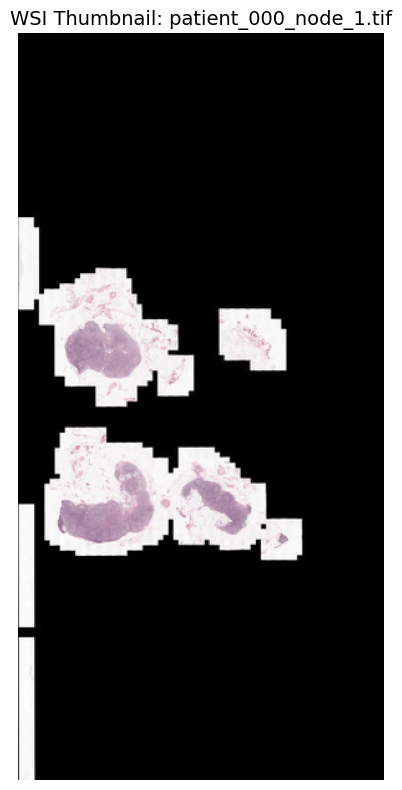

Visualization complete!


In [2]:
from source.visualization import visualize_example_wsi

visualize_example_wsi.visualize_wsi_thumbnail()

# Visual Analysis of WSI Thumbnails

The visualization above displays thumbnail images of lymph node tissue sections from different medical centers in the CAMELYON17 dataset. Each row represents a different hospital/site, and we can observe several important characteristics:

**Visual Observations:**
- **Staining Variations**: Different sites may show variations in H&E (Hematoxylin and Eosin) staining intensity and color balance, which can affect the pink and purple hues of the tissue
- **Tissue Preparation**: Variations in tissue sectioning thickness and preparation protocols may result in different tissue textures and clarity
- **Image Quality**: Different scanning equipment and protocols across hospitals may lead to variations in image resolution, brightness, and contrast
- **Tissue Types**: While all images show lymph node tissue, there may be variations in the specific anatomical regions captured and the amount of surrounding tissue included

These visual differences represent the core challenge of domain generalization - training a model that can perform well across all these visual variations while still accurately detecting metastatic tissue regardless of the source hospital's imaging characteristics.


# Tissue Segmentation with the CLAM Algorithm

In this step, we perform tissue segmentation on the Whole Slide Images (WSIs). The goal is to separate the tissue regions (foreground) from the empty slide background. This is a crucial preprocessing step that allows subsequent analyses, such as patch extraction, to focus solely on relevant areas, saving a significant amount of computation time.

We implement the segmentation algorithm described in the [CLAM (Clustering-constrained Attention Multiple Instance Learning)](https://arxiv.org/abs/2004.09666) paper. The process is as follows:

1.  **Downsampling**: The WSI is read at a low resolution (e.g., level 6, ~64x downsampling) for fast processing.
2.  **Color Space Conversion**: The image is converted from the RGB to the HSV (Hue, Saturation, Value) color space. The Saturation channel is particularly effective for distinguishing tissue from the white background.
3.  **Thresholding**: A binary mask is created by applying a threshold to the Saturation channel.
4.  **Noise Reduction**: A median blur is used to smooth the mask, and morphological closing operations are applied to fill small holes and gaps within the tissue regions.
5.  **Contour Filtering**: Finally, small non-tissue artifacts are removed by filtering out any detected regions (contours) that are smaller than a specific area threshold.

The following script processes each WSI, generates a final tissue mask, and saves a visualization comparing the original thumbnail, the mask, and the thumbnail with the background removed.

In [1]:
from source.preprocessing import segmentation

segmentation.process_all_slides(max_slides=5)

Processing a subset of 5 slides.

--- Processing: patient_000_node_0.tif ---
Using the lowest available resolution level: 8 for efficient segmentation.
Visualization saved to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_0/patient_000_node_0_visualization.png
Low-resolution mask saved to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_0/patient_000_node_0_low_res_mask.png
Parameters saved to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_0/patient_000_node_0_params.json

--- Processing: patient_000_node_1.tif ---
Using the lowest available resolution level: 8 for efficient segmentation.
Visualization saved to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_1/patient_000_node_1_visualization.png
Low-resolution mask saved to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_1/patient_000_node_1_low_res_mask.png
Parameters saved to: /home/d

# CONCH v1.5 Feature Extraction

In this section, we extract patch-level features from the WSI images using the CONCH v1.5 model from Hugging Face. CONCH (Contrastive Learning of Histopathology) is a state-of-the-art foundation model specifically designed for pathology images.

**Feature Extraction Process:**
- **Patch Division**: Each WSI is divided into non-overlapping 256x256 pixel patches (configurable)
- **Model**: Uses CONCH v1.5 with pre-trained weights optimized for pathology
- **Output Format**: Features are saved in HDF5 (.h5) format for efficient storage and retrieval
- **Optimization**: Batch processing and memory-efficient patch loading for large WSI files
- **Resumability**: Automatically skips already processed files to allow resuming interrupted runs

The extracted features will serve as input representations for downstream domain generalization models, capturing rich semantic information from the tissue patches while being more computationally manageable than raw pixel data.



